In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
np.random.seed(249)
xx, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
x_ = np.random.randn(100, 2)*0.1
xx = np.concatenate([xx, x_], axis=0)
y = np.concatenate([y, np.ones(len(x_), dtype=int)*0])

In [4]:
# np.random.seed(249) ## 148, 249

# xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
#                                       noise=.07)
# idx = yc==0
# xxc = xxc[idx]
# yc = yc[idx]

# idx = (xxc[:,0]+xxc[:,1]<1)
# xxc = xxc[idx]
# yc = yc[idx]


# xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
# xxm = xxm/2 - 0.2

# xx = np.concatenate((xxm, xxc), axis=0)
# y = np.concatenate((ym, yc+2), axis=0)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1]), array([250, 150]))

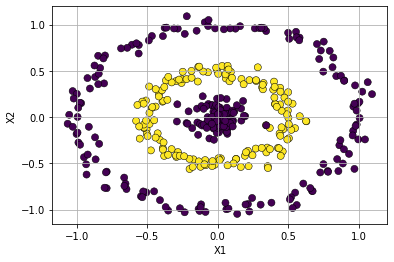

In [6]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.Tensor(y.reshape(-1, 1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [7]:
class ConnectedClassifier_Softmax(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.5
        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c

In [8]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c

In [9]:
# class ConnectedClassifier_SoftKMeans(nn.Module):
    
#     def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_sets = num_sets
#         self.inv_temp = nn.Parameter(torch.ones(1, num_sets)*inv_temp)
        
#         self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         init_val = torch.randn(num_sets, output_dim)*0.1
#         for ns in range(num_sets):
#             init_val[ns, ns%output_dim] = 1.
            
#         self.cls_weight = nn.Parameter(init_val.abs())
#         self.cls_confidence = None
        
        
#     def forward(self, x, hard=False):
# #         self.cls_weight.data.abs_()
# #         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
#         x = x[:, :self.input_dim]
#         dists = torch.cdist(x, self.centers)
#         dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
# #         dists = dists**2
#         if hard:
#             x = 1/(dists*1e5 + 1e-5)
#         else:
#             x = 1/(dists*self.inv_temp+1e-5)
        
#         x = x/x.data.sum(dim=1, keepdim=True)
        
#         self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
# #         c = self.cls_weight
#         return x@c

In [10]:
class LeakySignum(nn.Module):
    def forward(self, x):
        o1x = 0.1*x
        return torch.minimum(torch.maximum(x, o1x*0.0), o1x+0.9)

In [11]:
class LeakyRectFilter(nn.Module):
    def forward(self, x):
        x = x.abs()
#         return -torch.maximum(torch.minimum(0.1*x-0.15, x-1.5), 0.1*x-1.05)
        return -torch.maximum(torch.minimum(0.01*(x-1.5), x-1.5), 0.1*x-1.05)

In [39]:
class DistanceBinaryClassifier(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
#         self.actf = nn.Sigmoid()
        self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        
    def forward(self, x, hard=False):
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        if hard:
            x = torch.sigmoid(-x*1e5)
        else:
            x = self.actf(-x*self.inv_temp)
        return x

In [40]:
# dbc = DistanceBinaryClassifier(2)
# dbc(torch.randn(3, 2))

In [41]:
class LinearBinaryClassifier(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.actf = nn.Sigmoid()
#         self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()

        
    def forward(self, x, hard=False):
        x = self.linear(x)
        if hard:
            x = torch.sigmoid(x*1e5)
        else:
            x = self.actf(x*self.inv_temp)
        return x

In [42]:
model = nn.Sequential(nn.Linear(2, 10, bias=False),
                      nn.BatchNorm1d(10),
                      nn.SELU(),
                      nn.Linear(10, 2, bias=False),
                      nn.BatchNorm1d(2),
                      nn.SELU(),
                     )

In [43]:
# actf = irf.Swish
# flows = [
#     ActNorm(2),
#     irf.ResidualFlow(2, [5], activation=actf),
#     ActNorm(2),
#     irf.ResidualFlow(2, [5], activation=actf),
#     ActNorm(2),
#         ]

# model = SequentialFlow(flows)

In [44]:
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=False)
  (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
  (3): Linear(in_features=10, out_features=2, bias=False)
  (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): SELU()
)

In [45]:
# classifier = ConnectedClassifier_SoftKMeans(2, 10, 3)
# classifier = LinearBinaryClassifier(2)
classifier = DistanceBinaryClassifier(2, inv_temp=1)
# classifier.bias.data *= 0.

# classifier = nn.Sequential(nn.Linear(2,1), nn.Sigmoid())

## Model Train

In [46]:
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.01)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  64


In [47]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca()#projection='3d')

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

cls = 0
yc = (yy==cls).reshape(-1, 1).type(torch.float32)

for epoch in tqdm(range(1000*4+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, yc)
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data>0.5).type(torch.long)
        acc = float((acc==yc).type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear()
        model.eval()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z)
            
        yout_img = classifier(model(xyg))
        model.train()
        out = (yout_img.data.numpy()>0.5).astype(int)
#         out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()

        ax.scatter(x1, x2, c=yy.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')
            
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        
        fig.canvas.draw()
        plt.pause(0.01)


  0%|          | 0/4001 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.5844161510467529 Accuracy: 0.375


  2%|▏         | 86/4001 [00:00<00:19, 200.69it/s]

Epoch: 100 Loss: 0.06773842126131058 Accuracy: 0.9350000023841858


  4%|▍         | 165/4001 [00:01<00:18, 206.52it/s]

Epoch: 200 Loss: 0.040361274033784866 Accuracy: 0.9624999761581421


  7%|▋         | 288/4001 [00:01<00:15, 246.98it/s]

Epoch: 300 Loss: 0.005892394110560417 Accuracy: 0.9950000047683716


 10%|█         | 401/4001 [00:02<00:19, 185.54it/s]

Epoch: 400 Loss: 0.004525320138782263 Accuracy: 0.9975000023841858


 12%|█▏        | 482/4001 [00:02<00:13, 257.96it/s]

Epoch: 500 Loss: 0.004291129298508167 Accuracy: 0.9975000023841858


 15%|█▍        | 597/4001 [00:03<00:13, 260.36it/s]

Epoch: 600 Loss: 0.004401069134473801 Accuracy: 0.9975000023841858


 17%|█▋        | 676/4001 [00:03<00:14, 224.97it/s]

Epoch: 700 Loss: 0.003996255807578564 Accuracy: 0.9975000023841858


 20%|█▉        | 800/4001 [00:04<00:12, 256.80it/s]

Epoch: 800 Loss: 0.0035969424061477184 Accuracy: 0.9975000023841858


 22%|██▏       | 880/4001 [00:04<00:13, 232.10it/s]

Epoch: 900 Loss: 0.0052720773965120316 Accuracy: 0.9975000023841858


 25%|██▍       | 995/4001 [00:04<00:11, 264.97it/s]

Epoch: 1000 Loss: 0.0032555938232690096 Accuracy: 0.9975000023841858


 27%|██▋       | 1075/4001 [00:05<00:11, 250.30it/s]

Epoch: 1100 Loss: 0.0031179331708699465 Accuracy: 0.9975000023841858


 30%|██▉       | 1197/4001 [00:05<00:10, 263.92it/s]

Epoch: 1200 Loss: 0.0030533454846590757 Accuracy: 0.9975000023841858


 32%|███▏      | 1267/4001 [00:06<00:12, 214.26it/s]

Epoch: 1300 Loss: 0.0030123868491500616 Accuracy: 0.9975000023841858


 35%|███▍      | 1389/4001 [00:06<00:10, 255.15it/s]

Epoch: 1400 Loss: 0.002974714618176222 Accuracy: 0.9975000023841858


 38%|███▊      | 1502/4001 [00:07<00:12, 196.75it/s]

Epoch: 1500 Loss: 0.0029378258623182774 Accuracy: 0.9975000023841858


 39%|███▉      | 1569/4001 [00:07<00:09, 243.96it/s]

Epoch: 1600 Loss: 0.002901628613471985 Accuracy: 0.9975000023841858


 42%|████▏     | 1672/4001 [00:08<00:09, 238.86it/s]

Epoch: 1700 Loss: 0.002866285154595971 Accuracy: 0.9975000023841858


 44%|████▍     | 1777/4001 [00:08<00:08, 251.47it/s]

Epoch: 1800 Loss: 0.0028336914256215096 Accuracy: 0.9975000023841858


 47%|████▋     | 1892/4001 [00:09<00:08, 255.82it/s]

Epoch: 1900 Loss: 0.0028027836233377457 Accuracy: 0.9975000023841858


 49%|████▉     | 1970/4001 [00:09<00:09, 218.48it/s]

Epoch: 2000 Loss: 0.002775258384644985 Accuracy: 0.9975000023841858


 52%|█████▏    | 2074/4001 [00:10<00:08, 225.75it/s]

Epoch: 2100 Loss: 0.002749535720795393 Accuracy: 0.9975000023841858


 55%|█████▍    | 2194/4001 [00:10<00:07, 252.73it/s]

Epoch: 2200 Loss: 0.0027465312741696835 Accuracy: 0.9975000023841858


 57%|█████▋    | 2266/4001 [00:11<00:08, 211.81it/s]

Epoch: 2300 Loss: 0.0027238845359534025 Accuracy: 0.9975000023841858


 59%|█████▉    | 2375/4001 [00:11<00:07, 227.54it/s]

Epoch: 2400 Loss: 0.0026933883782476187 Accuracy: 0.9975000023841858


 62%|██████▏   | 2491/4001 [00:12<00:05, 252.09it/s]

Epoch: 2500 Loss: 0.0026312260888516903 Accuracy: 0.9975000023841858


 65%|██████▌   | 2601/4001 [00:12<00:07, 191.38it/s]

Epoch: 2600 Loss: 0.002582948189228773 Accuracy: 0.9975000023841858


 67%|██████▋   | 2679/4001 [00:13<00:05, 262.53it/s]

Epoch: 2700 Loss: 0.002606369787827134 Accuracy: 0.9975000023841858


 70%|██████▉   | 2795/4001 [00:13<00:04, 264.53it/s]

Epoch: 2800 Loss: 0.0024608236271888018 Accuracy: 0.9975000023841858


 72%|███████▏  | 2873/4001 [00:14<00:04, 243.85it/s]

Epoch: 2900 Loss: 0.2311708778142929 Accuracy: 0.625


 75%|███████▍  | 2989/4001 [00:14<00:03, 263.52it/s]

Epoch: 3000 Loss: 0.15691877901554108 Accuracy: 0.7099999785423279


 77%|███████▋  | 3068/4001 [00:14<00:03, 237.98it/s]

Epoch: 3100 Loss: 0.003809809684753418 Accuracy: 0.9975000023841858


 79%|███████▉  | 3178/4001 [00:15<00:03, 242.17it/s]

Epoch: 3200 Loss: 0.0032836548052728176 Accuracy: 0.9975000023841858


 82%|████████▏ | 3299/4001 [00:15<00:02, 260.84it/s]

Epoch: 3300 Loss: 0.003000915050506592 Accuracy: 0.9975000023841858


 84%|████████▍ | 3378/4001 [00:16<00:02, 242.30it/s]

Epoch: 3400 Loss: 0.002770288847386837 Accuracy: 0.9975000023841858


 86%|████████▋ | 3458/4001 [00:16<00:02, 228.30it/s]

Epoch: 3500 Loss: 0.002593946410343051 Accuracy: 0.9975000023841858


 89%|████████▉ | 3565/4001 [00:17<00:01, 226.89it/s]

Epoch: 3600 Loss: 0.002444543642923236 Accuracy: 0.9975000023841858


 92%|█████████▏| 3681/4001 [00:17<00:01, 250.26it/s]

Epoch: 3700 Loss: 0.002339012688025832 Accuracy: 0.9975000023841858


 95%|█████████▍| 3795/4001 [00:18<00:00, 243.72it/s]

Epoch: 3800 Loss: 0.0022047969978302717 Accuracy: 0.9975000023841858


 97%|█████████▋| 3869/4001 [00:18<00:00, 214.26it/s]

Epoch: 3900 Loss: 0.002005655085667968 Accuracy: 0.9975000023841858


 99%|█████████▉| 3973/4001 [00:19<00:00, 205.67it/s]

Epoch: 4000 Loss: 0.0018813631031662226 Accuracy: 0.9975000023841858


100%|██████████| 4001/4001 [00:19<00:00, 201.38it/s]


In [48]:
yout 

tensor([[1.0061],
        [1.0367],
        [-0.0000],
        [-0.0000],
        [1.0473],
        [-0.0000],
        [-0.0000],
        [0.9793],
        [-0.0000],
        [0.9904],
        [-0.0000],
        [1.0481],
        [1.0356],
        [1.0419],
        [1.0274],
        [1.0077],
        [-0.0000],
        [1.0408],
        [1.0435],
        [1.0493],
        [-0.0000],
        [-0.0000],
        [1.0167],
        [-0.0000],
        [-0.0000],
        [1.0360],
        [1.0299],
        [-0.0000],
        [1.0443],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [0.9761],
        [1.0001],
        [1.0001],
        [-0.0000],
        [-0.0000],
        [1.0052],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [1.0334],
        [1.0306],
        [-0.0000],
        [-0.0000],
        [1.0376],
        [1.0475],

In [1610]:
yy

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
      

In [ ]:
classifier.inv_temp

In [1524]:
yout.min(), yout.max(), yout.mean()

(tensor(-0.), tensor(1.1001), tensor(0.2598))

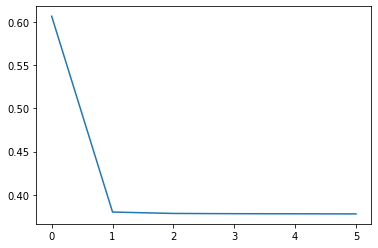

In [1525]:
%matplotlib inline
plt.plot(losses)

In [1526]:
### Binary classification using output change

## Train MultiClass Classifier Binary

In [96]:
ycls = yy.reshape(-1).type(torch.long)

In [102]:
actf = irf.Swish
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [5], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [5], activation=actf),
    ActNorm(2),
        ]

model = SequentialFlow(flows)

In [103]:
classifier = ConnectedClassifier_SoftKMeans(2, 6, ycls.max().item()+1, inv_temp=1)
# classifier = ConnectedClassifier_Softmax(2, 2, 2)

In [104]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.01)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  68


In [111]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca()#projection='3d')

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

for epoch in tqdm(range(1000*4+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, ycls)
    loss.backward()
    if epoch < 2000:
        model.zero_grad()
    
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data.argmax(dim=1) == ycls)
        acc = float(acc.type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z, hard=True)
            
        yout_img = classifier(model(xyg), hard=True)
#         out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.argmax(dim=1).numpy()
#         print(out.shape)
#         out = yout_img.data[torch.arange(0, len(out), dtype=torch.long), out.reshape(-1)].numpy()
#         print(out.shape)
        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()

        ax.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.argmax(dim=1).numpy().reshape(-1), marker='.')
            
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        
        fig.canvas.draw()
        plt.pause(0.01)


  0%|          | 0/4001 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.004360543098300695 Accuracy: 0.9975000023841858


  2%|▏         | 86/4001 [00:00<00:30, 130.19it/s]

Epoch: 100 Loss: 0.00434077437967062 Accuracy: 0.9975000023841858


  5%|▍         | 186/4001 [00:01<00:27, 136.82it/s]

Epoch: 200 Loss: 0.0043219407089054585 Accuracy: 0.9975000023841858


  7%|▋         | 283/4001 [00:02<00:26, 139.54it/s]

Epoch: 300 Loss: 0.004303881898522377 Accuracy: 0.9975000023841858


 10%|▉         | 385/4001 [00:03<00:24, 147.07it/s]

Epoch: 400 Loss: 0.004286585375666618 Accuracy: 0.9975000023841858


 12%|█▏        | 486/4001 [00:04<00:24, 144.55it/s]

Epoch: 500 Loss: 0.004270009230822325 Accuracy: 0.9975000023841858


 15%|█▍        | 584/4001 [00:05<00:24, 137.27it/s]

Epoch: 600 Loss: 0.004254111088812351 Accuracy: 0.9975000023841858


 17%|█▋        | 687/4001 [00:06<00:22, 146.24it/s]

Epoch: 700 Loss: 0.004238825291395187 Accuracy: 0.9975000023841858


 20%|█▉        | 791/4001 [00:07<00:22, 145.47it/s]

Epoch: 800 Loss: 0.004224146716296673 Accuracy: 0.9950000047683716


 22%|██▏       | 891/4001 [00:08<00:21, 142.97it/s]

Epoch: 900 Loss: 0.004210017621517181 Accuracy: 0.9950000047683716


 25%|██▍       | 996/4001 [00:09<00:20, 149.77it/s]

Epoch: 1000 Loss: 0.004196421708911657 Accuracy: 0.9950000047683716


 27%|██▋       | 1084/4001 [00:09<00:20, 144.65it/s]

Epoch: 1100 Loss: 0.004183371551334858 Accuracy: 0.9950000047683716


 30%|██▉       | 1190/4001 [00:10<00:18, 152.12it/s]

Epoch: 1200 Loss: 0.004170790780335665 Accuracy: 0.9950000047683716


 32%|███▏      | 1290/4001 [00:11<00:19, 140.09it/s]

Epoch: 1300 Loss: 0.004158645402640104 Accuracy: 0.9950000047683716


 35%|███▍      | 1393/4001 [00:12<00:18, 143.87it/s]

Epoch: 1400 Loss: 0.00414702482521534 Accuracy: 0.9950000047683716


 37%|███▋      | 1494/4001 [00:13<00:18, 138.15it/s]

Epoch: 1500 Loss: 0.004135799594223499 Accuracy: 0.9950000047683716


 40%|███▉      | 1595/4001 [00:14<00:16, 145.58it/s]

Epoch: 1600 Loss: 0.004124958999454975 Accuracy: 0.9950000047683716


 40%|███▉      | 1600/4001 [00:14<00:21, 109.83it/s]


TclError: invalid command name "pyimage259"

In [106]:
yout

tensor([[  5.2251,  -4.1055],
        [  5.2244,  -4.1048],
        [ -3.4433,   4.5015],
        [-15.5883,  16.6231],
        [  6.2306,  -5.1588],
        [-15.6847,  16.7193],
        [ -5.0555,   6.1156],
        [  9.5968,  -8.5445],
        [ -2.7588,   3.8212],
        [  8.8258,  -7.7480],
        [ -6.4240,   7.4822],
        [  5.1334,  -4.0144],
        [  5.2249,  -4.1052],
        [  5.2246,  -4.1050],
        [ 10.2477,  -9.1957],
        [ 10.2865,  -9.2346],
        [ -2.9235,   3.9857],
        [  6.4851,  -5.4102],
        [  5.1365,  -4.0173],
        [ 10.4210,  -9.3690],
        [ -6.3438,   7.4021],
        [ -2.6637,   3.7235],
        [  9.5944,  -8.5424],
        [-15.6056,  16.6403],
        [ -4.3273,   5.3882],
        [  7.0883,  -6.0132],
        [  5.1249,  -4.0062],
        [ -3.1095,   4.1715],
        [ 11.9286, -10.8467],
        [ -5.4543,   6.5137],
        [ -2.5164,   3.5793],
        [ -3.9241,   4.9814],
        [ 10.3708,  -9.3189],
        [ 

In [124]:
classifier.inv_temp

Parameter containing:
tensor([6.0269], requires_grad=True)

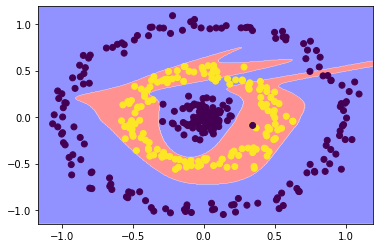

In [125]:
model.eval()
%matplotlib inline

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

with torch.no_grad():
    z = model(xyg, False)
    y = torch.argmax(classifier(z), dim=1)
    
cf = plt.contourf(xg, yg, y.reshape(xg.shape),# v,
                     alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, marker='o', c=yy.reshape(-1))

In [126]:
cls = torch.argmax(classifier.cls_confidence, dim=1)
for i, u in enumerate(torch.unique(cls)):
    cls[cls==u] = i

cf = plt.contourf(xg, yg, cls.reshape(xg.shape),# v,
                     alpha=0.5, cmap=matplotlib.cm.tab10, antialiased=True)
plt.scatter(x1, x2, marker='o', c=yy.reshape(-1))

ModuleAttributeError: 'DistanceBinaryClassifier' object has no attribute 'cls_confidence'

In [1239]:
classifier.centers.data.t()

tensor([[-0.2992, -0.2933, -0.2992],
        [-1.1095,  2.1947, -1.0998]])

## Train, non-softmax based classifier


In [112]:
#### if we use same distance scaler, then same always increasing function, we get same argmax db

In [113]:
class LeakySignum(nn.Module):
    def forward(self, x):
        o1x = 0.1*x
        return torch.minimum(torch.maximum(x, o1x), o1x+0.9)

In [114]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
            
        self.cls_weight = nn.Parameter(init_val.abs())
        self.cls_confidence = None
        
#         self.actf = LeakySignum()
        self.actf = nn.Sigmoid()
        
        
    def forward(self, x, hard=False):
        self.cls_weight.data.abs_()
        self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
#         dists = dists**2
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
#             x = torch.sigmoid(-dists*self.inv_temp)
            x = self.actf(-dists*self.inv_temp)

            
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c

In [115]:
class DistanceBinaryClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.actf = nn.Sigmoid()
#         self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        self.pos_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        self.neg_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        
    def forward(self, x, hard=False):
        self.pos_val.data.abs_()
        self.pos_val.data = self.pos_val.data/self.pos_val.data.sum()
        self.neg_val.data.abs_()
        self.neg_val.data = self.neg_val.data/self.neg_val.data.sum()
        
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        if hard:
            x = torch.sigmoid(-x*1e5)
        else:
            x = self.actf(-x*self.inv_temp)
        x = x*self.pos_val + (1-x)*self.neg_val
        return x

In [116]:
ycls = yy.reshape(-1).type(torch.long)

ycls_ = torch.zeros(len(ycls), ycls.max()+1)
ycls_[torch.arange(0, len(ycls), dtype=torch.long), ycls] = 1.

In [117]:
ycls_, ycls

(tensor([[1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1.

In [118]:
actf = irf.Swish
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [5], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [5], activation=actf),
    ActNorm(2),
        ]

model = SequentialFlow(flows)

In [119]:
# classifier = ConnectedClassifier_SoftKMeans(2, 5, ycls.max().item()+1, inv_temp=1)
classifier = DistanceBinaryClassifier(2, ycls.max().item()+1, inv_temp=1)

In [120]:
criterion = nn.MSELoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.0031)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  68


In [128]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca()#projection='3d')

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

for epoch in tqdm(range(1000*4+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, ycls_)
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data.argmax(dim=1) == ycls)
        acc = float(acc.type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z)
            
        yout_img = classifier(model(xyg))
        out = yout_img.data.argmax(dim=1).numpy()
#         out = yout_img.data[torch.arange(0, len(out), dtype=torch.long), out.reshape(-1)].numpy()
        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, antialiased=True)
        ax.grid()

        ax.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.argmax(dim=1).numpy().reshape(-1), marker='.')
            
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        
        fig.canvas.draw()
        plt.pause(0.01)


  0%|          | 0/4001 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.017324291169643402 Accuracy: 0.9825000166893005


  2%|▏         | 99/4001 [00:01<00:28, 134.79it/s]

Epoch: 100 Loss: 0.01735280267894268 Accuracy: 0.9825000166893005


  5%|▍         | 198/4001 [00:02<00:27, 137.93it/s]

Epoch: 200 Loss: 0.01728818006813526 Accuracy: 0.9825000166893005


  7%|▋         | 293/4001 [00:02<00:24, 153.36it/s]

Epoch: 300 Loss: 0.017294464632868767 Accuracy: 0.9825000166893005


 10%|▉         | 387/4001 [00:03<00:27, 133.65it/s]

Epoch: 400 Loss: 0.017269814386963844 Accuracy: 0.9825000166893005


 12%|█▏        | 499/4001 [00:04<00:22, 158.42it/s]

Epoch: 500 Loss: 0.01724814809858799 Accuracy: 0.9825000166893005


 15%|█▍        | 595/4001 [00:05<00:25, 136.20it/s]

Epoch: 600 Loss: 0.017246248200535774 Accuracy: 0.9825000166893005


 17%|█▋        | 691/4001 [00:06<00:21, 151.19it/s]

Epoch: 700 Loss: 0.017236877232789993 Accuracy: 0.9825000166893005


 20%|█▉        | 800/4001 [00:07<00:29, 106.90it/s]

Epoch: 800 Loss: 0.01721842959523201 Accuracy: 0.9825000166893005


TclError: invalid command name "pyimage281"

In [122]:
yout

tensor([[0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.0033, 0.9967],
        [0.0033, 0.9967],
        [0.9777, 0.0223],
        [0.0032, 0.9968],
        [0.0031, 0.9969],
        [0.9777, 0.0223],
        [0.0031, 0.9969],
        [0.9777, 0.0223],
        [0.0093, 0.9907],
        [0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.0051, 0.9949],
        [0.9777, 0.0223],
        [0.9128, 0.0872],
        [0.9777, 0.0223],
        [0.0031, 0.9969],
        [0.0032, 0.9968],
        [0.9777, 0.0223],
        [0.0046, 0.9954],
        [0.0031, 0.9969],
        [0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.0037, 0.9963],
        [0.9777, 0.0223],
        [0.0034, 0.9966],
        [0.0032, 0.9968],
        [0.0032, 0.9968],
        [0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.9777, 0.0223],
        [0.0032, 0.9968],
        [0.0031, 0.9969],
        [0.9777, 0.0223],
        [0.0

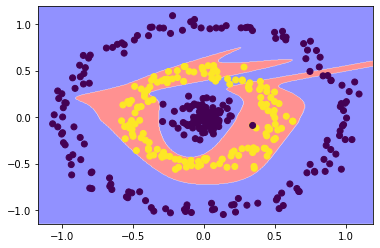

In [127]:
model.eval()
%matplotlib inline

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

with torch.no_grad():
    z = model(xyg, False)
    y = torch.argmax(classifier(z, hard=True), dim=1)
    
cf = plt.contourf(xg, yg, y.reshape(xg.shape),# v,
                     alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, marker='o', c=yy.reshape(-1))

In [123]:
torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True)

ModuleAttributeError: 'DistanceBinaryClassifier' object has no attribute 'cls_confidence'

In [ ]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

In [ ]:
plt.scatter(z[:,0], z[:,1], marker='.', c=cls, cmap='tab10')   
centers = torch.zeros(classifier.num_sets, z.shape[1])
for i, c in enumerate(classifier.centers.data.t()):
    centers[:, i] = c
plt.scatter(*centers.t(), marker='*', s=300, edgecolors='k', c=list(range(classifier.num_sets)), cmap='tab10')

In [ ]:
torch.unique(cls)

In [ ]:
torch.unique(cls, return_counts=True)

In [ ]:
list(range(classifier.num_sets))

In [ ]:
x__ = x_*(centers.max())
classifier(x__)
cls_ = torch.argmax(classifier.cls_confidence, dim=1)
# for i, u in enumerate(torch.unique(cls_)):
#     cls_[cls_==u] = i
plt.scatter(x__[:,0], x__[:,1], marker='.', c=cls_, cmap='tab10') 
plt.scatter(*centers.t(), marker='*', s=100, edgecolors='k', c=list(range(classifier.num_sets)), cmap='tab10')

In [ ]:
model.eval()

ng = 20
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)
z = model(x)
print(z.shape)

x = x.detach().numpy()
z = z.detach().numpy()
plt.figure(figsize=(20,20))
plt.scatter(z[:,0], z[:,1], c='r', s=5)
z = z.reshape(ng, ng, -1)
for i in range(ng):
    plt.plot(z[:, i, 0], z[:, i, 1], marker='.')
for i in range(ng):
    plt.plot(z[i, :, 0], z[i, :, 1], marker='.')
    
plt.title('x -> z')